In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 12, 10
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product

In [2]:
data = pd.read_csv('Sunspots.csv')
data = data.rename(columns={'Monthly Mean Total Sunspot Number':'Sunspots'})
data = data.drop('Unnamed: 0', axis=1)
data.info()
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace = True)
#data['Sunspots'] = pd.to_numeric(data['Sunspots'], downcast='float')
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      3265 non-null   object 
 1   Sunspots  3265 non-null   float64
dtypes: float64(1), object(1)
memory usage: 51.1+ KB


,Sunspots
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
...,...
2020-09-30,0.6
2020-10-31,14.4
2020-11-30,34.0


In [3]:
print(data['Sunspots'].unique())

[ 96.7 104.3 116.7 ...   3.1   9.4  21.8]


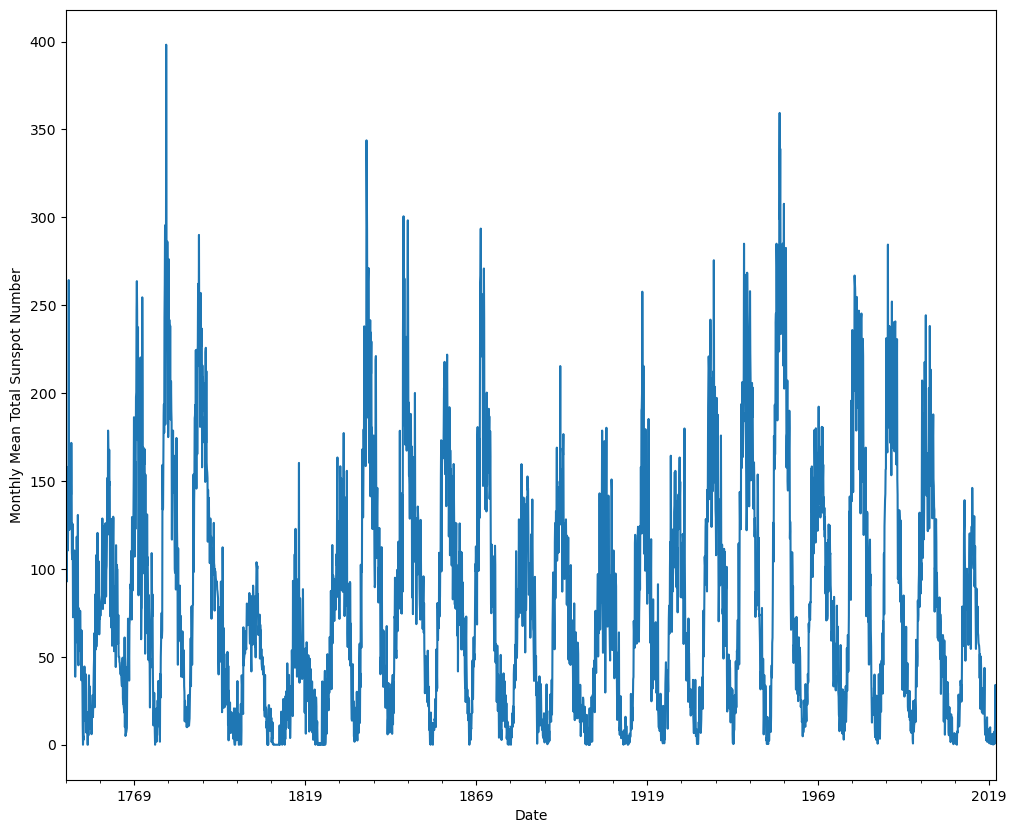

In [4]:
data['Sunspots'].plot()
plt.ylabel('Monthly Mean Total Sunspot Number');

Критерий Дики-Фуллера: p=0.000000
(-10.497051662546143, 1.1085524921956343e-18, 28, 3236, {'1%': -3.4323724026124003, '5%': -2.8624335760905684, '10%': -2.5672456699774324}, 29834.491003687108)


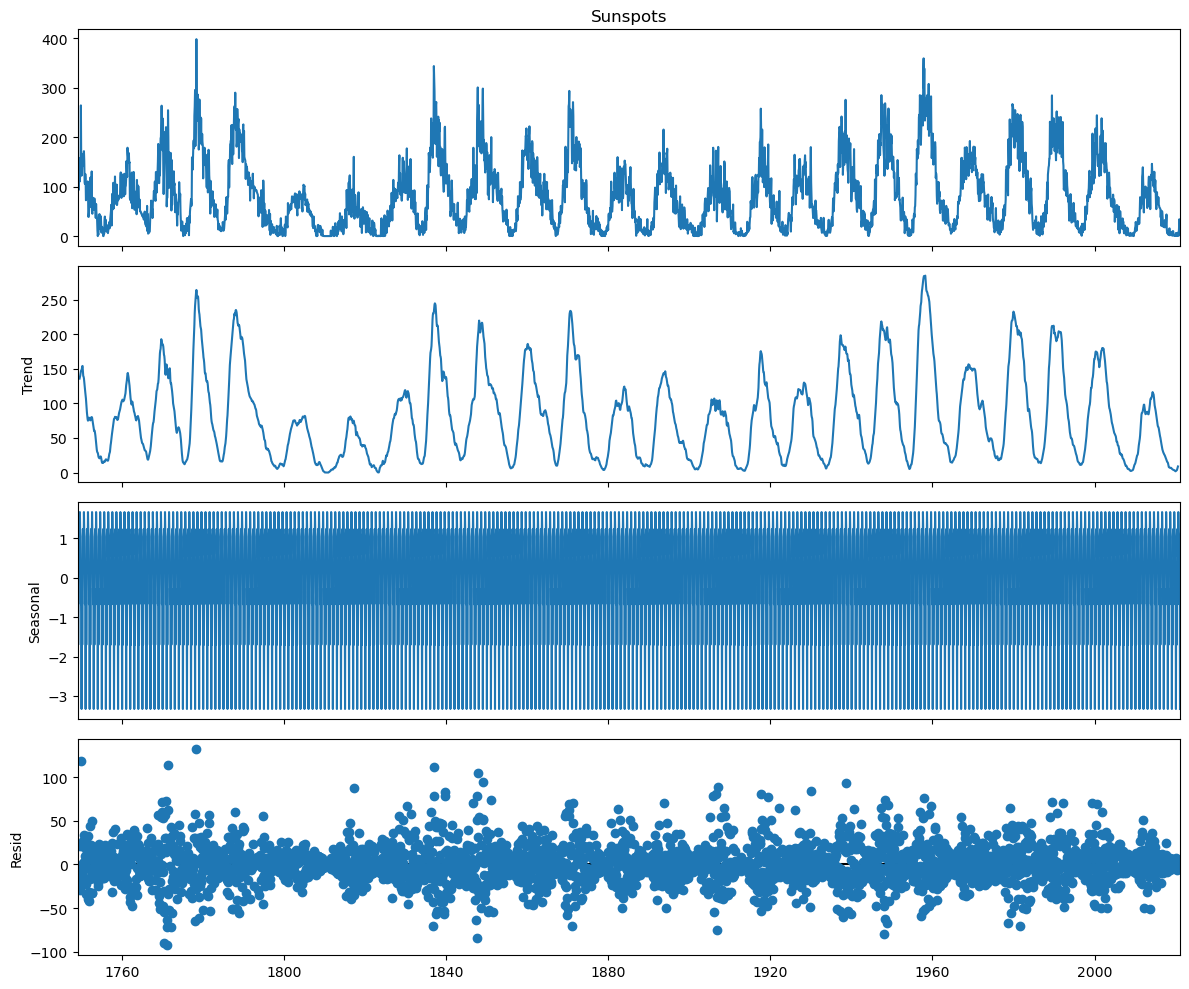

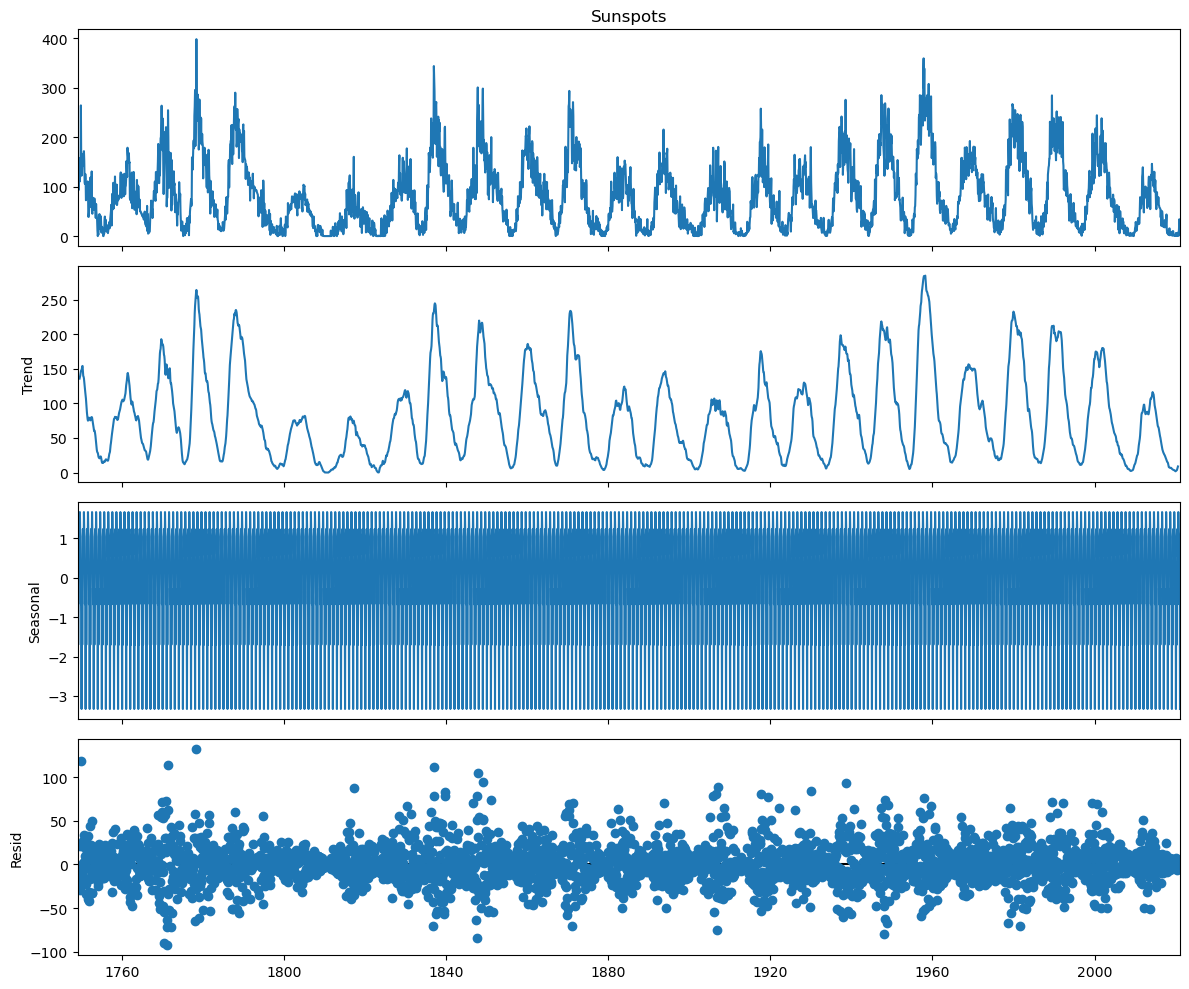

In [5]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['Sunspots'])[1])
print(sm.tsa.stattools.adfuller(data['Sunspots']))
sm.tsa.seasonal_decompose(data['Sunspots']).plot()

Критерий Дики-Фуллера: p=0.000000


(-13.877198799854646,
 6.306660701724896e-26,
 26,
 3188,
 {'1%': -3.432402877410845,
  '5%': -2.8624470364005785,
  '10%': -2.5672528359839046},
 31560.94859368076)

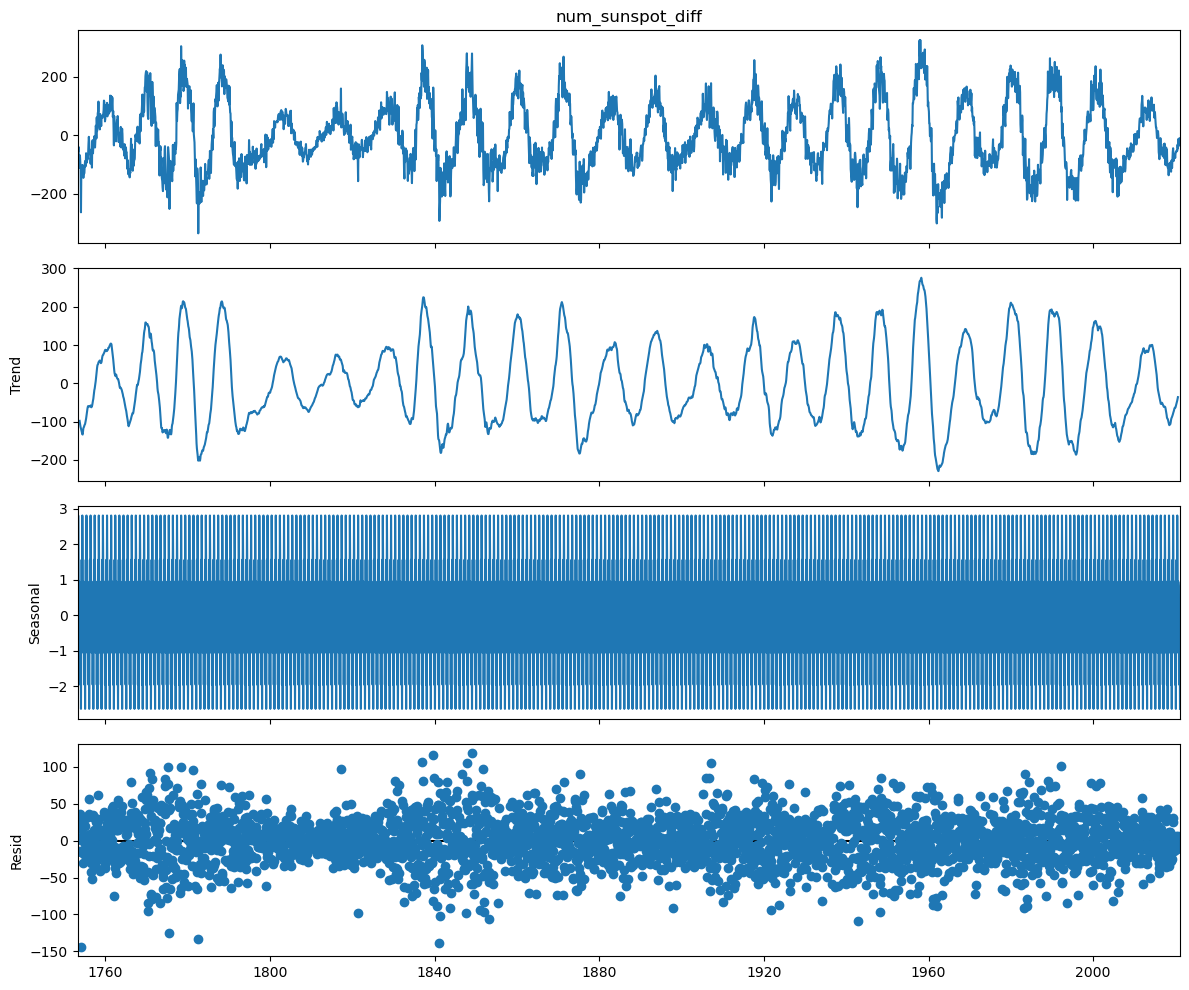

In [6]:
i = 50
data['num_sunspot_diff'] = data['Sunspots'] - data['Sunspots'].shift(i)
sm.tsa.seasonal_decompose(data['num_sunspot_diff'][i:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['num_sunspot_diff'][i:])[1])
sm.tsa.stattools.adfuller(data['num_sunspot_diff'][i:])

Критерий Дики-Фуллера: p=0.000000


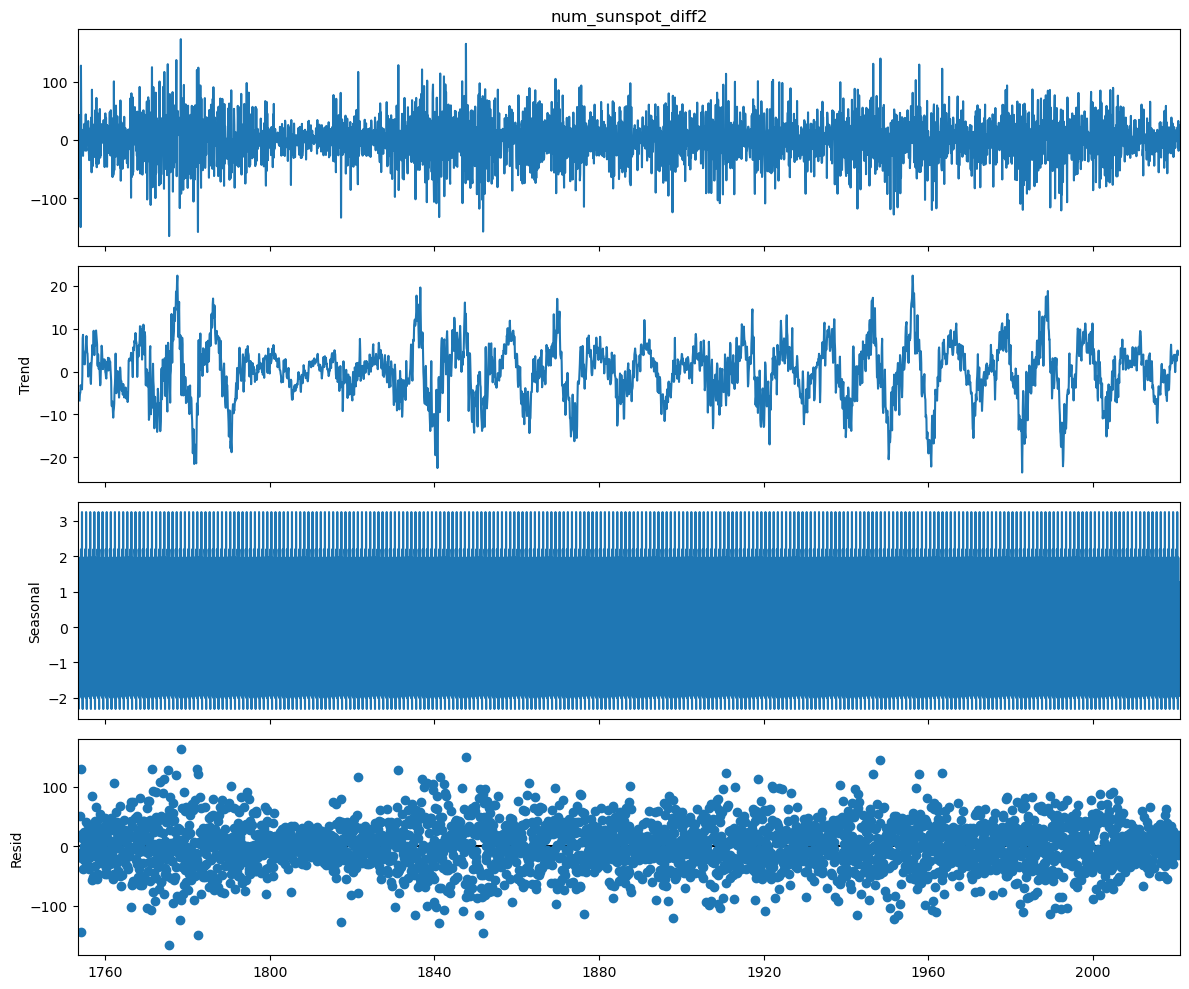

In [7]:
j = 1
data['num_sunspot_diff2'] = data['num_sunspot_diff'] - data['num_sunspot_diff'].shift(j)
sm.tsa.seasonal_decompose(data['num_sunspot_diff2'][i+j:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['num_sunspot_diff2'][i+j:])[1])

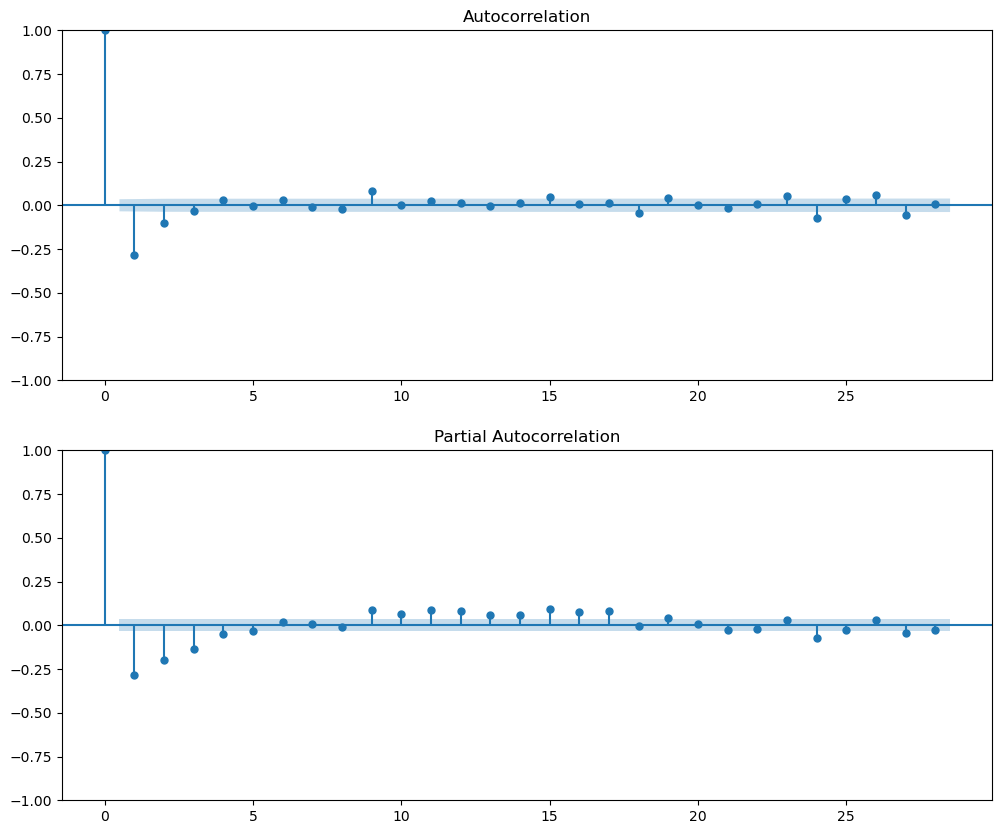

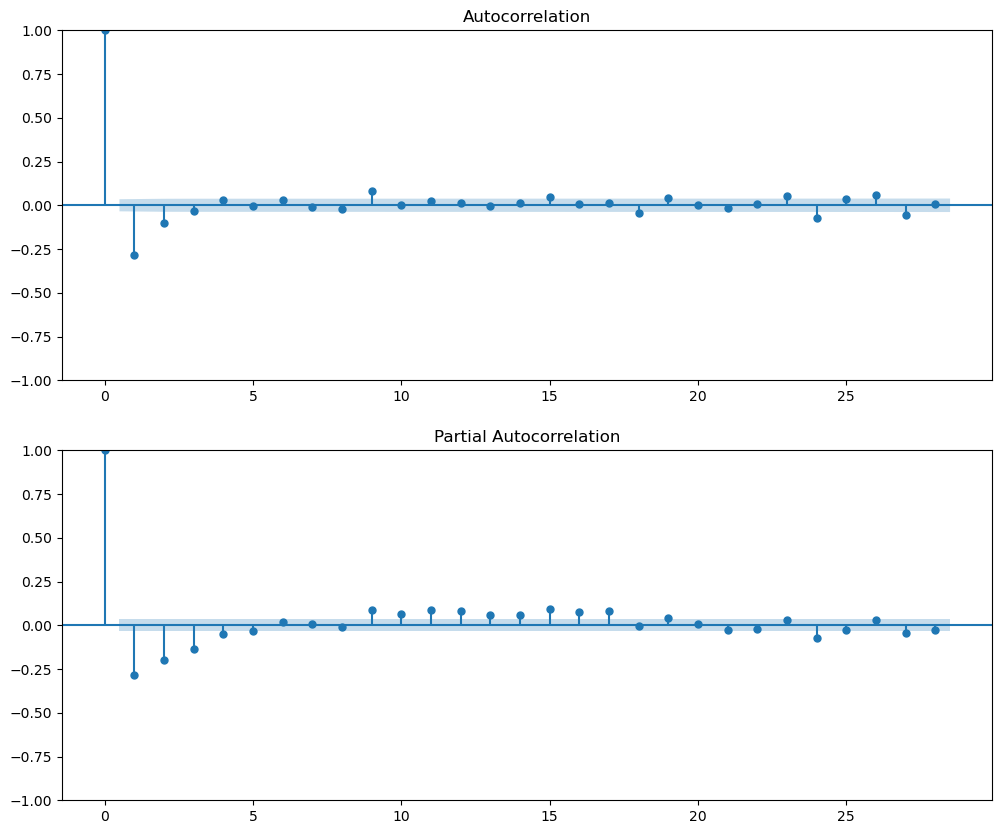

In [8]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['num_sunspot_diff2'][i+j:].values.squeeze(), lags=28, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['num_sunspot_diff2'][i+j:].values.squeeze(), lags=28, ax=ax)

In [9]:
ps = range(0, 3)
d=1
qs = range(0, 1)
Ps = range(0, 3)
D=1
Qs = range(0, 3)

In [10]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

27

In [11]:

%%time
import warnings
results = []
best_aic = float("inf")



for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['Sunspots'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

/home/gea/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/gea/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/gea/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/gea/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/gea/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred fre

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
22  (2, 0, 1, 1)  30329.434533
20  (2, 0, 0, 2)  30329.457862
25  (2, 0, 2, 1)  30329.767845
19  (2, 0, 0, 1)  30329.774915
26  (2, 0, 2, 2)  30333.283545


In [ ]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             Sunspots   No. Observations:                 3265
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 24)   Log Likelihood              -15159.717
Date:                              Thu, 26 Oct 2023   AIC                          30329.435
Time:                                      09:28:37   BIC                          30359.851
Sample:                                  01-31-1749   HQIC                         30340.333
                                       - 01-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3635      0.013    -27.859      0.000      -0.389      -0.338
ar.L2         -0.21

Критерий Стьюдента: p=0.931038
Критерий Дики-Фуллера: p=0.000000


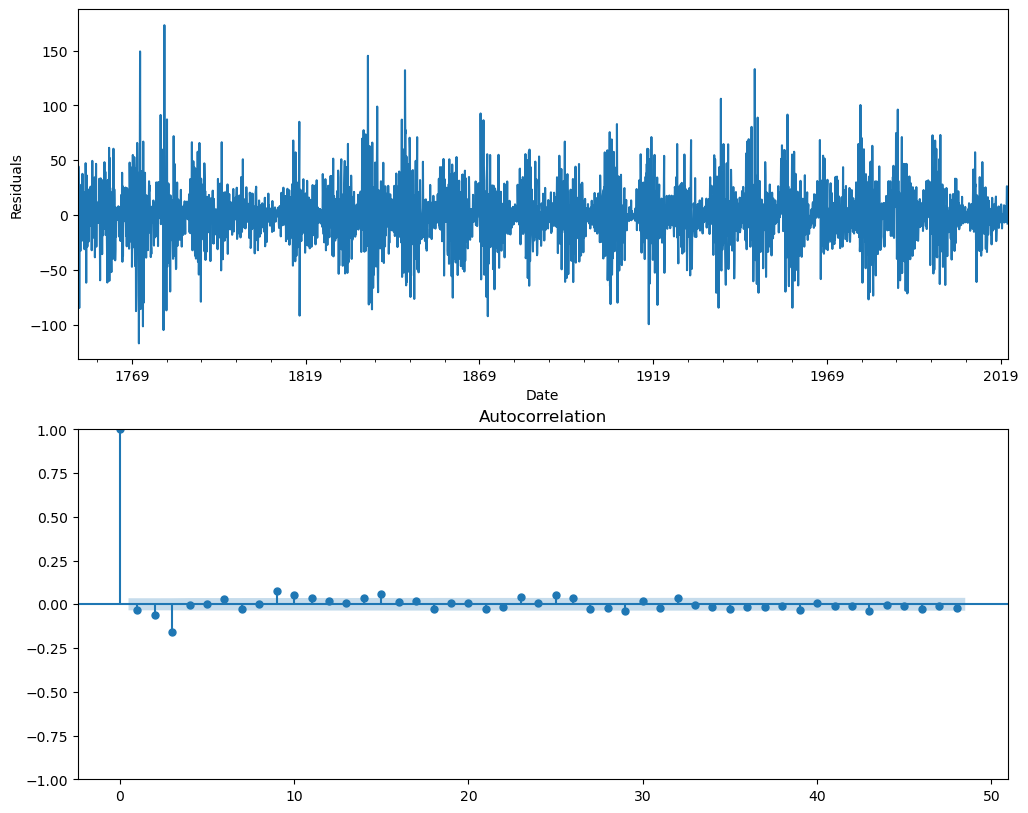

In [ ]:
plt.subplot(211)
best_model.resid[i+j:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[i+j:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[i+j:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[i+j:])[1])

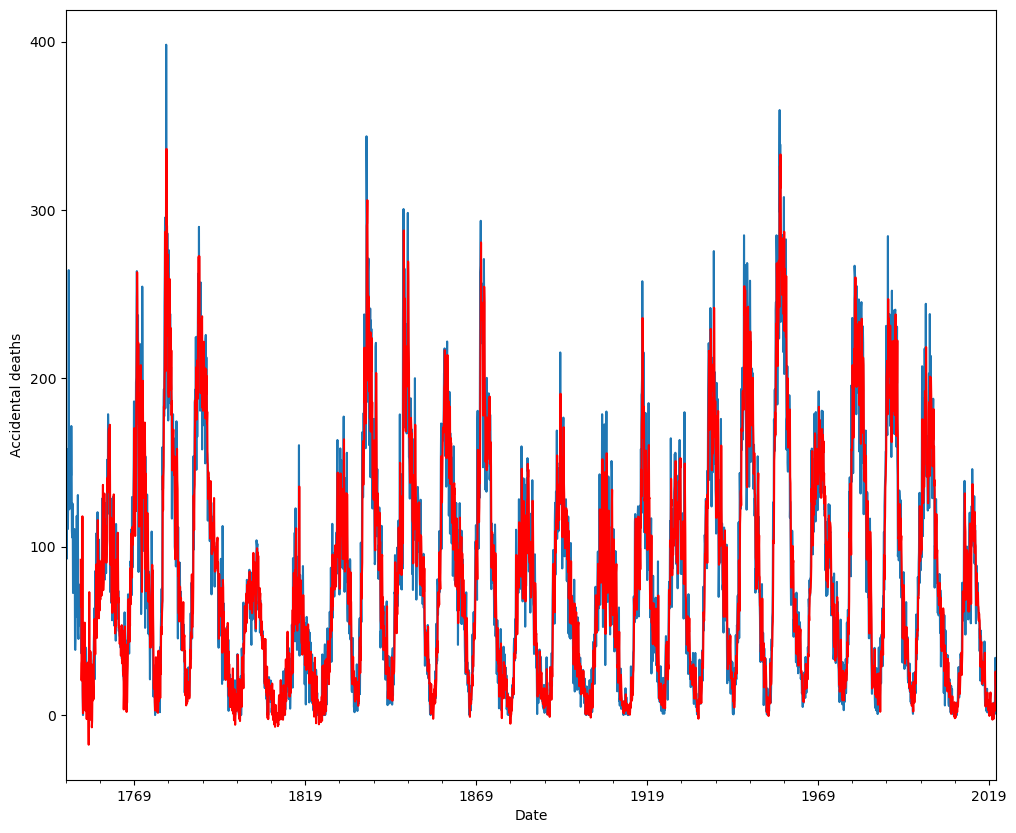

In [ ]:
data['model'] = best_model.fittedvalues
data['Sunspots'].plot()
data['model'][i+j:].plot(color='r')
plt.ylabel('Accidental deaths');

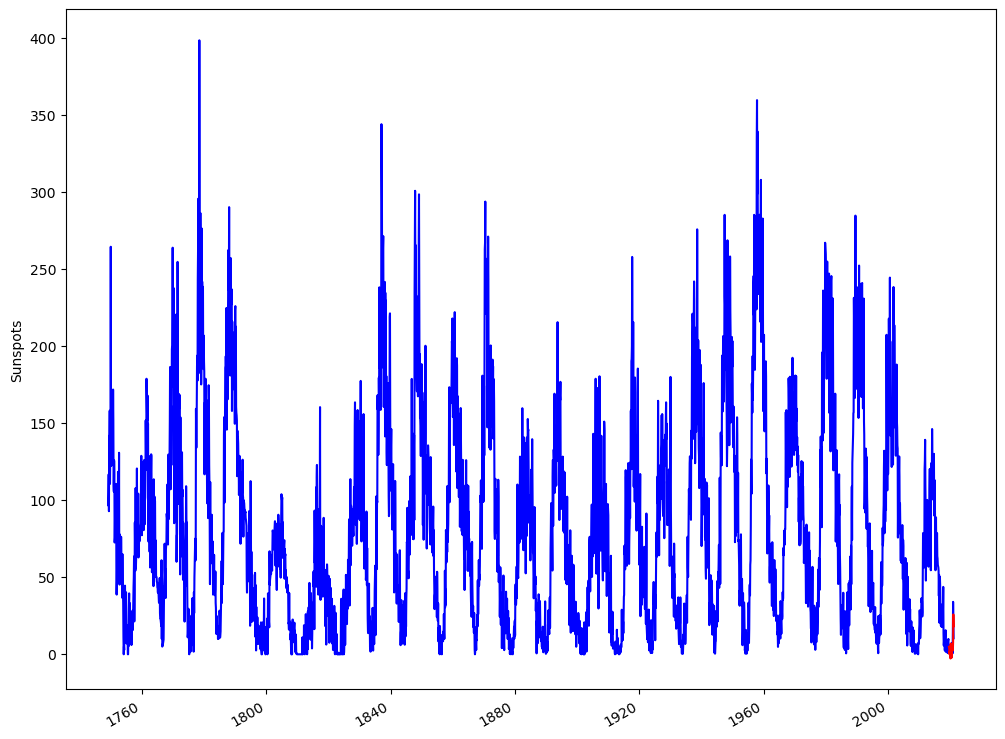

In [ ]:
from dateutil.relativedelta import relativedelta
import datetime
data2 = data[['Sunspots']]
date_list = [datetime.datetime.strptime("2022-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,300)]
future = pd.DataFrame(index=date_list, columns=data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = best_model.predict(start=3246, end=3565)

data2['Sunspots'].plot(color='b')
data2['forecast'].plot(color='r')
plt.ylabel('Sunspots');

In [ ]:
pd.DataFrame(date_list).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   0       300 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.5 KB


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3265 entries, 1749-01-31 to 2021-01-31
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sunspots           3265 non-null   float64
 1   num_sunspot_diff   3215 non-null   float64
 2   num_sunspot_diff2  3213 non-null   float64
 3   model              3265 non-null   float64
dtypes: float64(4)
memory usage: 127.5 KB


In [ ]:
pd.DataFrame(future).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2022-01-01 to 2046-12-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sunspots  0 non-null      object
dtypes: object(1)
memory usage: 4.7+ KB


In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3565 entries, 1749-01-31 to 2046-12-01
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sunspots  3265 non-null   float64
 1   forecast  19 non-null     float64
dtypes: float64(2)
memory usage: 83.6 KB


In [ ]:
data2.iloc[3240:3270]

,Sunspots,forecast
2019-01-31,7.7,NaN
2019-02-28,0.8,NaN
2019-03-31,9.4,NaN
2019-04-30,9.1,NaN
2019-05-31,9.9,NaN
2019-06-30,1.2,NaN
2019-07-31,0.9,4.869915
2019-08-31,0.5,4.219315
2019-09-30,1.1,0.081517
2019-10-31,0.4,1.596203


In [ ]:
data

,Sunspots,num_sunspot_diff,num_sunspot_diff2,model
Date,,,,
1749-01-31,96.7,NaN,NaN,0.000000
1749-02-28,104.3,NaN,NaN,96.677566
1749-03-31,116.7,NaN,NaN,104.288895
1749-04-30,92.8,NaN,NaN,116.700527
1749-05-31,141.7,NaN,NaN,92.809195
...,...,...,...,...
2020-09-30,0.6,-31.8,13.6,6.938306
2020-10-31,14.4,-35.8,-22.8,2.549801
2020-11-30,34.0,-10.6,21.2,7.692445
